In [64]:
from utility import *

from collections import Counter
from scipy.stats import ks_2samp

import matplotlib.pyplot as plt
import numpy as np
import random
import pandas as pd
import seaborn as sns

%matplotlib inline

# Dataset Loading

### The data sets needed for the loaders can be found at snap.stanford.edu/decagon. The side effect information was curated from the TWOSIDES, OFFSIDES, and Sider databases.

#### combo: drug ID pair
#### stitch: individual drug ID starting with CID
#### se: side effect ID starting with C

In [65]:
combo2stitch, combo2se, se2name = load_combo_se(fname='../data/csv/bio-decagon-combo.csv')
net, node2idx = load_ppi('../data/csv/bio-decagon-ppi.csv')
stitch2se, se2name_mono = load_mono_se('../data/csv/bio-decagon-mono.csv')
stitch2proteins = load_targets(fname='../data/csv/bio-decagon-targets.csv')
se2class, se2name_class = load_categories('../data/csv/bio-decagon-effectcategories.csv') # standard naming file
se2name.update(se2name_mono) # add or update value in side effect name extracted from combo file with mono file
se2name.update(se2name_class) # add or update value in side effect name extracted from combo file with category file

print('***' * 30)
print('total unique side effect name: %d' % len(set(se2name.values())))

****************************** Reading: ../data/csv/bio-decagon-combo.csv ******************************
Drug combinations number: 63473 Unique side effects number: 1317
Drug-drug interactions number: 4649441
Unique drug number: 645
****************************** Reading: ../data/csv/bio-decagon-ppi.csv ******************************
PPI Edges: 715612
PPI Nodes: 19081
****************************** Reading: ../data/csv/bio-decagon-mono.csv ******************************
Individual drug side effect total number: 174977
Unique drug number: 639
Unique side effect number : 10184
****************************** Reading: ../data/csv/bio-decagon-targets.csv ******************************
Drug-protein interaction: 18690
****************************** Reading: ../data/csv/bio-decagon-effectcategories.csv ******************************
unique side effect class number: 37
unique side effect name: 561
******************************************************************************************
total u

# Basic Statistics

## How many side effects does each drug combination have?

In [23]:
def plot_distribution(dist, title="", x_label="", y_label="", file_name=None):
    plt.figure(figsize=(6, 3.5))
    sns.set_context("paper", font_scale=1.8)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    sns.distplot(dist, kde=False, color=sns.xkcd_rgb['red'], bins=20, hist_kws={"alpha" : 1})
    plt.xlabel(x_label)
    plt.title(title)
    plt.tight_layout()
    plt.gcf().subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2)
    plt.ylabel(y_label)
    if file_name:
        plt.savefig(file_name)


Median number of side effects per drug combination 53.0


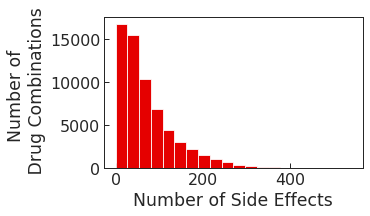

In [24]:
distribution_combos = [len(combo2se[combo]) for combo in combo2se.keys()]
print("Median number of side effects per drug combination", np.median(distribution_combos))
plot_distribution(distribution_combos, "", "Number of Side Effects", "Number of \n Drug Combinations", "")

In [28]:
combo2se

defaultdict(set,
            {'CID000002173_CID000003345': {'C0000731',
              'C0001122',
              'C0002063',
              'C0003578',
              'C0003611',
              'C0003615',
              'C0003962',
              'C0004144',
              'C0004604',
              'C0007785',
              'C0010692',
              'C0013182',
              'C0013274',
              'C0013384',
              'C0013404',
              'C0016199',
              'C0016204',
              'C0018790',
              'C0019080',
              'C0020040',
              'C0020440',
              'C0020456',
              'C0020517',
              'C0020542',
              'C0020598',
              'C0020615',
              'C0020649',
              'C0020672',
              'C0021845',
              'C0023518',
              'C0023798',
              'C0024115',
              'C0030446',
              'C0030790',
              'C0031154',
              'C0032326',
              'C00

## How frequent are different side effects?

In [29]:
from IPython.display import display, HTML

def get_se_counter(se_map):
    side_effects = []
    for drug in se_map:
        side_effects += list(set(se_map[drug]))
    return Counter(side_effects)

combo_counter = get_se_counter(combo2se)

print("Most common side effects in drug combinations:")
common_se = []
common_se_counts = []
common_se_names = []
for se, count in combo_counter.most_common(964):
    common_se += [se]
    common_se_counts += [count]
    common_se_names += [se2name[se]]
df = pd.DataFrame(data={"Side Effect": common_se, "Frequency in Drug Combos": common_se_counts, "Name": common_se_names})  
display(df)

Most common side effects in drug combinations:


,Side Effect,Frequency in Drug Combos,Name
0,C0020649,28568,arterial pressure NOS decreased
1,C0002871,27006,anaemia
2,C0013404,26037,Difficulty breathing
3,C0027497,25190,nausea
4,C0032285,24430,neumonia
5,C0015672,24260,Fatigue
6,C0030193,23894,Pain
7,C0011991,23848,diarrhea
8,C0004093,23515,asthenia
9,C0042963,23043,emesis


In [45]:
combo_counter.items()

dict_items([('C0000731', 12369), ('C0019080', 14143), ('C0020598', 10633), ('C0020040', 6664), ('C0018790', 12501), ('C0003615', 1805), ('C0030446', 8164), ('C0020440', 1831), ('C0220981', 8259), ('C0004144', 12062), ('C0030790', 219), ('C0020517', 11218), ('C0013182', 9358), ('C0034063', 12309), ('C0016199', 4663), ('C0020649', 28568), ('C0243026', 16575), ('C0007785', 8223), ('C1145670', 15961), ('C0013274', 790), ('C0038000', 469), ('C0242429', 5708), ('C0158986', 1206), ('C0038379', 1995), ('C0034150', 3479), ('C0020615', 12443), ('C0035220', 507), ('C0235896', 8465), ('C0242184', 11805), ('C0151714', 387), ('C0032326', 5342), ('C0003962', 8979), ('C0002063', 356), ('C0013384', 7126), ('C0031154', 4407), ('C0003578', 4030), ('C0024115', 8557), ('C0040034', 17060), ('C0023518', 7669), ('C0013404', 26037), ('C0023798', 9754), ('C0001122', 8621), ('C0236124', 460), ('C0016204', 7915), ('C0020456', 18779), ('C0035222', 7161), ('C0003611', 1190), ('C0085631', 14192), ('C0428977', 12141)

### Plot of Side Effect Frequency

##### We find that >53% of polypharmacy side effects are known to occur in <3% of the documented drug combinations (e.g. cerebral artery embolism, lung ab- scess, sarcoma, collagen disorder). In contrast, the more frequent side effects, (e.g. vomiting, weight gain, nausea and anaemia), occur an order of magnitude more often. Due to the large variation in the number of drug pairs each side effect is associated with, there are only a limited number of drug pairs available for independently training models for prediction of different side effect types. As a re- sult, polypharmacy side-effect prediction becomes a challenging task, especially when predicting rarer side effects, and

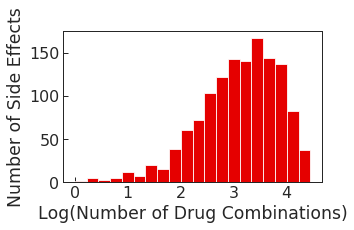

In [42]:
plot_distribution(np.log10(np.asarray(list(zip(*combo_counter.items()))[1])), "",  "Log(Number of Drug Combinations)", "Number of Side Effects", file_name="se_combodist.pdf")

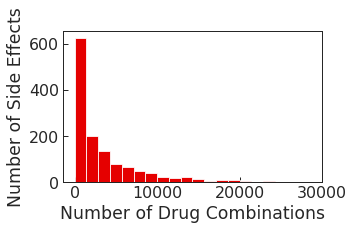

In [44]:
plot_distribution((np.asarray(list(zip(*combo_counter.items()))[1])), "",  "Number of Drug Combinations", "Number of Side Effects", file_name="se_combodist.pdf")

# Side Effect Cooccurrence in Drug Combinations

In [68]:
combos = combo2se.keys()
combo_probability_distribution = np.asarray([len(combo2se[combo])*1.0 for combo in combo2se])
combo_probability_distribution = combo_probability_distribution/np.sum(combo_probability_distribution)

se2combo = defaultdict(set)
for combo in combo2se:
    for se in combo2se[combo]:
        se2combo[se].add(combo)


We observe that polypharmacy side effects do not appear independently of one another in co-prescribed drug pairs (\ie, drug combinations), suggesting that joint modeling over multiple side effects can aid in the prediction task. To quantify the co-occurrence between side effects, we count the number of drug combinations in which a given side effect co-occurs with other side effects, and then use permutation testing with a null model of random co-occurrence. As exemplified for hypertension and nausea below, we find that the majority of the most common side effects are either significantly overrepresented or underrepresented with respect to how often they co-occur with nausea/hypertension as side effects in drug combinations, at $\alpha=0.05$. 

In [50]:
# Permutation test testing the significancy between the drug combinations a side effect occurs in,
# as compared to other common side effects
def run_permutation_test(se_oi, num_permutations = 2000):
    se_oi_combos = se2combo[se_oi]
    side_effects = []
    names = []
    real_overlaps = []
    mean_permuted_overlap = []
    probabilities = []
    for se, count in combo_counter.most_common(51):
        if se == se_oi:
            continue
        real_combos = se2combo[se]
        real_overlap = len(real_combos.intersection(se_oi_combos))
        permuted_overlaps = []
        for i in range(num_permutations):
            combo_sample = np.random.choice(list(combos), len(real_combos), replace=False, p=combo_probability_distribution)
            permuted_overlaps += [len(se_oi_combos.intersection(set(combo_sample)))]
        probability = np.sum(np.asarray(permuted_overlaps) >= real_overlap)*1.0/num_permutations
        side_effects += [se]
        names += [se2name[se]]
        real_overlaps += [real_overlap]
        mean_permuted_overlap += [np.mean(permuted_overlaps)]
        probabilities += [probability]
    df = pd.DataFrame(data={"Side Effect": side_effects, "True Overlap": real_overlaps, "Mean Permuted Overlap": mean_permuted_overlap, "Probability True < Permuted": probabilities, "Name": names})  
    df = df[['Side Effect', 'Name', 'True Overlap', 'Mean Permuted Overlap', 'Probability True < Permuted']]
    display(df)

In [51]:
# For hypertension
run_permutation_test('C0020538')

KeyboardInterrupt: 

In [ ]:
# For nausea
run_permutation_test('C0027497')

# How similar are the drug target profiles of drug combinations?

Third, we probe the relationship between proteins targeted by a drug pair and occurrence of side effects. Let $T_i$ represent a set of target proteins associated with drug $i$, we then calculate the Jaccard similarity between target proteins of a given drug pair $(i,j)$ as: $\text{Jaccard}(i,j) = |T_i \cap T_j|/|T_i \cup T_j|$.  
We see most drug combinations have zero target proteins in common, random drug pairs have smaller overlap in targeted proteins than co-prescribed drugs, andthat this trend is unequally observed across different side effects. 

In [90]:
def jaccard(set1, set2):
    num = len(set(set1).intersection(set(set2)))
    den = len(set(set1).union(set(set2)))
    return num*1.0/den

# Only examining those drugs we have drug target information for
valid = []
for stitch in stitch2se:
    if len(stitch2proteins[stitch]) > 0:
        valid += [stitch]
        
# Jaccard similarity between drug target profiles of drugs in drug combinations
jaccard_combos = {}
for combo in combo2se.keys():
    stitch1, stitch2 = combo2stitch[combo]
    if stitch1 in valid and stitch2 in valid:
        jaccard_combos[combo] = jaccard(stitch2proteins[stitch1], stitch2proteins[stitch2])

# Jaccard similarity between drug target profiles of random drugs
jaccard_random = []
for i in range(10000):
    stitch1 = np.random.choice(valid, 1, replace=False)[0]
    stitch2 =  np.random.choice(valid, 1, replace=False)[0]
    jaccard_random += [jaccard(stitch2proteins[stitch1], stitch2proteins[stitch2])] 
jaccard_random = np.asarray(jaccard_random)

In [91]:
import pandas as pd

def plot_jaccard_distribution_multiple(ses):
    group_names = {'Random drug pairs': jaccard_random, 'All drug combinations': np.asarray([jaccard_combos[combo] for combo in jaccard_combos])}
    order = ['Random drug pairs', 'All drug combinations'] + [nicknames[se] for se in ses]
    for se in ses:
        se_combos = se2combo[se].intersection(set(jaccard_combos.keys()))
        in_jaccard = np.asarray([jaccard_combos[combo] for combo in se_combos])
        group_name = nicknames[se]
        group_names[group_name] = in_jaccard
    categories = {'No shared drug targets': (-.01, 0), 'Fewer than 50% shared': (0, 0.5), 'More than 50% shared':(0.5, 1)}
    groups, similarities, fractions = [], [], []
    for name in group_names:
        arr = group_names[name]
        for category in categories: 
            min_val, max_val = categories[category]
            value = np.sum((arr > min_val) * (arr <= max_val))*1.0/len(arr)
            groups += [name]
            similarities += [category]
            fractions += [value]
    data = pd.DataFrame({ '' : groups, 'Jaccard Similarity Between Drug Target Profiles': similarities, 'Fraction of Drug Combinations': fractions})
    plt.figure(figsize=(3, 5))
    sns.set_context("paper", font_scale=6)
    sns.set_style('ticks')
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in"})
    g = sns.factorplot(x="Jaccard Similarity Between Drug Target Profiles", y="Fraction of Drug Combinations", hue="", data=data,
                   size=18, kind="bar")
    plt.tight_layout()
    plt.xlabel('')
    plt.savefig('multiple_dist.pdf')


/anaconda3/envs/py3-6/lib/python3.6/site-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/anaconda3/envs/py3-6/lib/python3.6/site-packages/seaborn/categorical.py:3672: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


<Figure size 216x360 with 0 Axes>

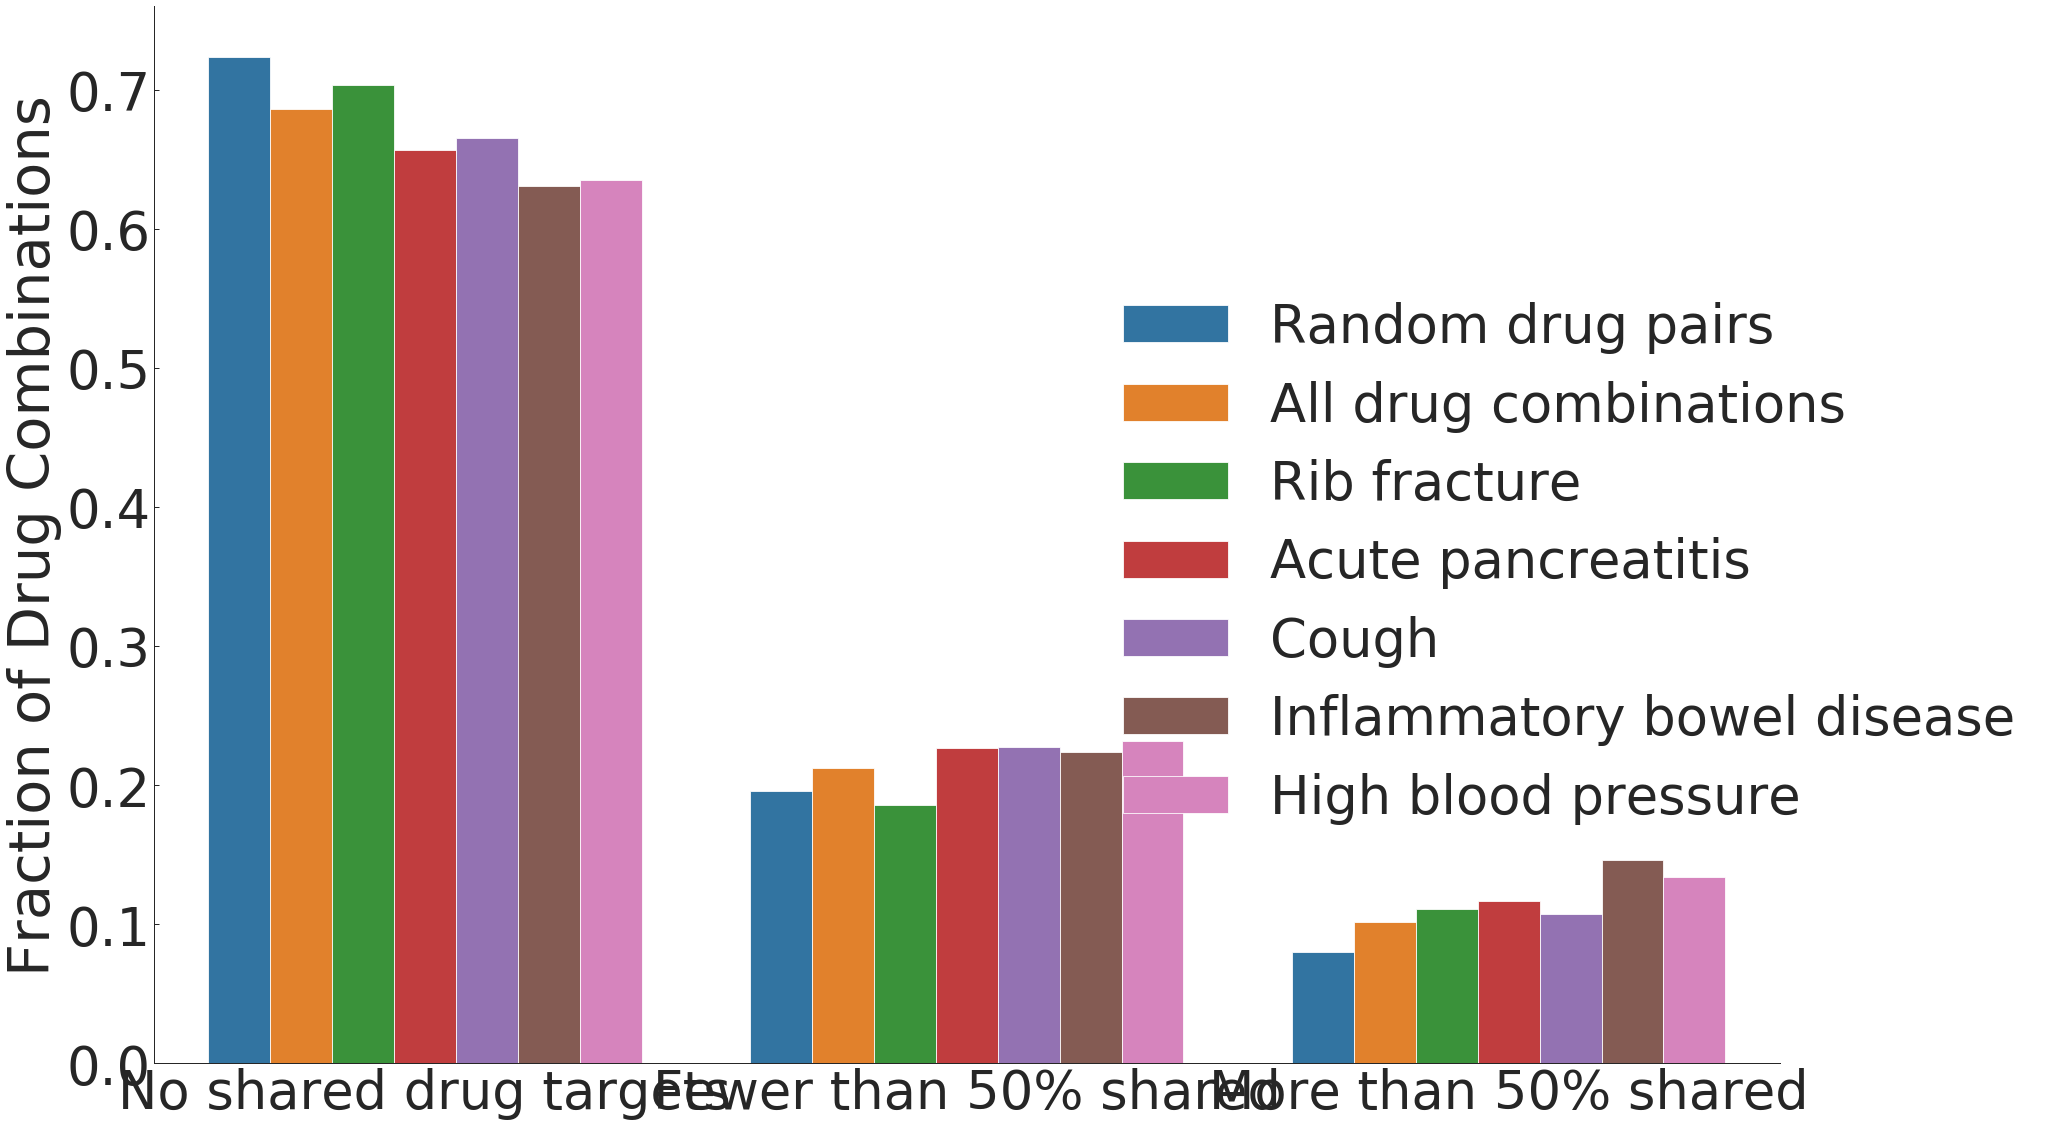

In [92]:
nicknames = {'C0035522': 'Rib fracture', 'C0001339': 'Acute pancreatitis', 'C0010200': 'Cough', 'C0021390': 'Inflammatory bowel disease', 'C0020538': 'High blood pressure'}

plot_jaccard_distribution_multiple(['C0035522', 'C0001339',  'C0010200', 'C0021390', 'C0020538'])